# Imports and Data Information

In [ ]:
# Regression model
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.formula.api import logit
# Auxiliary functions for stepwise model selection and feature naming
from auxiliary_functions import *
# Analyzing regression results
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Data methods
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from scipy import stats
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import forestplot as fp

## Dataset

In [ ]:
cmv = pd.read_csv("data/enriched_datasets/cmv_all_features.csv", sep="\t")

In [4]:
target_col = 'persuasiveness'

storytelling = ['storytelling_mixed_domain', 'storytelling_one_domain']
storytelling_probs = ['prob_storytelling_mixed_domain', 'prob_storytelling_one_domain']

hedging = ['first_abs_hedge', 'first_hedge', 'final_abs_hedge', 'final_hedge', 'global_abs_hedge', 'avg_hedge']

As explained in the paper, the experiments are done with the average prediction probabilities of the _mixed-domain storytelling_ and _masked emotion_ classifiers, which for emotion is further _aggregated_ from predictions for two halves of an instance. Due to the annotation process however, there are multiple further variants for these features. All possible feature variants are included in the dataset and are listed here to simplify future experiments. The table below gives an overview of annotation fields, including accumulated hyperclasses and modified features:

This results in the following features:

| **Variable/feature name** | **Feature**|
|---|---|
| - | text_id |
| `target_col` | Binary label of dependent variable (DV), data field _persuasiveness_ |
| `emotion_orig` | Binary aggregated emotion labels predicted with original training data, _anger\_orig, boredom\_orig, disgust\_orig, fear\_orig, guilt\_shame\_orig, joy\_orig, pride\_orig, relief\_orig, sadness\_orig, trust\_orig_ |
| `emotion_masked` | Binary aggregated emotion labels predicted with original training data, _anger\_masked, boredom\_masked, disgust\_masked, fear\_masked, guilt\_shame\_masked, joy\_masked, pride\_masked, relief\_masked, sadness\_masked, trust\_masked_ |
| `negative_[masked/orig]` | Binary feature denoting the presence of any negative emotion aggregated from the classification results of _anger, boredom, disgust, fear, guilt/shame_ and _sadness_ of the corresponding classifier (`masked`, `unmasked`) |
| `positive_[masked/orig]` | Binary feature for the presence of any positive emotion aggregated from _joy, pride, relief, surprise, trust_ |
| `emotionality_[masked/orig]` | Sum of all predicted emotions for one training variant (`masked`, `unmasked`), the feature can adapt values [0;11] depending on how many of the eleven emotions were predicted for the instance |
| `prob_emo_[masked/orig]` | Output probabilities of the _masked/original_ classifier for emotion features |
| `emotion[_probs]_[masked/orig]_progression` | $\Delta$ of the emotion prediction of the first and second half of each instance, i.e., instead of aggregating, the two values are subtracted, -1 to 1, based on either probability output or binary label |
| `emotion[_probs]_[masked/orig]_whole` | Probability output or binary label of the emotion classifiers on the whole instance |
| `emotion[_probs]_[masked/orig]_[beginning/end]` | Probability output or binary label of the emotion classifiers on the first or second half of an instance |
| `hedging` | Absolute and relative hedge counts for the first, last and all sentences of an instance, _avg\_hedge, final\_abs\_hedge, final\_hedge, first\_abs\_hedge, first\_hedge, global\_abs\_hedge_ |
| `story` | Binary storytelling labels, _storytelling\_one\_domain, storytelling\_mixed\_domain_ |
| `prob_story` | Prediction probabilities from storytelling classifiers, _prob\_storytelling\_mixed\_domain, prob\_storytelling\_one\_domain_ |

In [ ]:
# Binary aggregated prediction based on masked training data
emotion_masked = [
    'anger_masked_agg', 'boredom_masked_agg', 'disgust_masked_agg', 
    'fear_masked_agg', 'guilt_shame_masked_agg', 'joy_masked_agg', 
    'pride_masked_agg', 'relief_masked_agg', 'sadness_masked_agg', 
    'trust_masked_agg'
]
# Prediction probabilities based on masked training data
# This is the relevant feature variant used below
emotion_probs_masked = [
    'prob_anger_masked_agg', 'prob_boredom_masked_agg', 'prob_disgust_masked_agg', 
    'prob_fear_masked_agg', 'prob_guilt_shame_masked_agg', 'prob_joy_masked_agg', 
    'prob_pride_masked_agg', 'prob_relief_masked_agg', 'prob_sadness_masked_agg', 
    'prob_trust_masked_agg'
    ]
# Emotion difference between binary predictions for two halves of an instance based on masked training data
emotion_masked_progression = [
    'anger_masked_progress', 'boredom_masked_progress', 'disgust_masked_progress', 
    'fear_masked_progress', 'guilt_shame_masked_progress', 'joy_masked_progress', 
    'pride_masked_progress', 'relief_masked_progress', 'sadness_masked_progress', 
    'trust_masked_progress'
]
# Emotion difference between probabilities of two halves of an instance based on masked training data
emotion_probs_masked_progression = [
    'prob_anger_masked_progress', 'prob_boredom_masked_progress', 'prob_disgust_masked_progress', 
    'prob_fear_masked_progress', 'prob_guilt_shame_masked_progress', 'prob_joy_masked_progress', 
    'prob_pride_masked_progress', 'prob_relief_masked_progress', 'prob_sadness_masked_progress', 
    'prob_trust_masked_progress'
    ]
# Binary emotion prediction for the whole instance based on masked training data
emotion_masked_whole = [
    'anger_masked', 'boredom_masked', 'disgust_masked', 
    'fear_masked', 'guilt_shame_masked', 'joy_masked', 
    'pride_masked', 'relief_masked', 'sadness_masked', 
    'trust_masked'
    ]
# Emotion prediction probability for the whole instance based on masked training data
emotion_probs_masked_whole = [
    'prob_anger_masked', 'prob_boredom_masked', 'prob_disgust_masked', 
    'prob_fear_masked', 'prob_guilt_shame_masked', 'prob_joy_masked', 
    'prob_pride_masked', 'prob_relief_masked', 'prob_sadness_masked', 
    'prob_trust_masked'
    ]


# Binary aggregated prediction based on original training data
emotion_orig = [
    'anger_orig_agg', 'boredom_orig_agg', 'disgust_orig_agg', 
    'fear_orig_agg', 'guilt_shame_orig_agg', 'joy_orig_agg', 
    'pride_orig_agg', 'relief_orig_agg', 'sadness_orig_agg', 
    'trust_orig_agg'
]
# Prediction probabilities based on original training data
emotion_probs_orig = [
    'prob_anger_orig_agg', 'prob_boredom_orig_agg', 'prob_disgust_orig_agg', 
    'prob_fear_orig_agg', 'prob_guilt_shame_orig_agg', 'prob_joy_orig_agg', 
    'prob_pride_orig_agg', 'prob_relief_orig', 'prob_sadness_orig', 
    'prob_trust_orig_agg'
]
# Emotion difference between binary predictions for two halves of an instance based on original training data
emotion_orig_progression = [
    'anger_orig_progress', 'boredom_origgress', 'disgust_orig_progress', 
    'fear_origgress', 'guilt_shame_orig_progress', 'joy_origgress', 
    'pride_orig_progress', 'relief_origgress', 'sadness_orig_progress', 
    'trust_origgress'
]
# Emotion difference between probabilities of two halves of an instance based on original training data
emotion_probs_orig_progression = [
    'prob_anger_orig_progress', 'prob_boredom_orig_progress', 'prob_disgust_origgress', 
    'prob_fear_orig_progress', 'prob_guilt_shame_orig_progress', 'prob_joy_origgress', 
    'prob_pride_origgress', 'prob_relief_unm_origgress', 'prob_sadness_orig_progress', 
    'prob_trust_orig_progress'
]
# Binary emotion prediction for the whole instance based on original training data
emotion_orig_whole = [
    'anger_orig', 'boredom_orig', 'disgust_orig', 
    'fear_orig', 'guilt_shame_orig', 'joy_orig', 
    'pride_orig', 'relief_orig', 'sadness_orig', 
    'trust_orig'
]
# Emotion prediction probability for the whole instance based on original training data
emotion_probs_orig_whole = [
    'prob_anger_orig', 'prob_boredom_orig', 'prob_disgust_orig', 
    'prob_fear_orig', 'prob_guilt_shame_orig', 'prob_joy_orig', 
    'prob_pride_orig', 'prob_relief_orig', 'prob_sadness_orig', 
    'prob_trust_orig'
]

In [6]:
y = cmv.loc[:, "persuasiveness"]

### Data distribution

In [ ]:
dist_cols = emotion_probs_masked + storytelling_probs
l = len(cmv)
print("Overall number of instances:", l)
m = len(max(dist_cols, key=lambda x:len(x)))
x = f"{'Feature': <31} - {'#': ^4} / ratio\t\t{'Feature': <31} - {'#': ^4} / ratio\n{'_'*46}\t\t{'_'*46}\n"
for i, co in enumerate(dist_cols):
    x += f"{co: <31} - {int(round(cmv[co].sum(),0)): >4} / {round(cmv[co].sum()/l, 3): <5}"
    if i%2:
        x +="\n"
    else: x +="\t\t"
print(x)

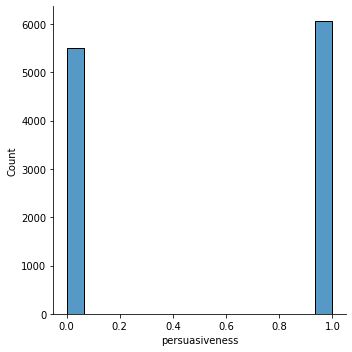

In [9]:
sns.displot(cmv, x="persuasiveness")

# Separate Regression for Individual Features
To explore different feature variants, each of the following models will have just one independent variable, sorted by variable type: 
1. emotion
    - masked
    - unmasked
2. storytelling
    - mixed domain
    - one domain
3. hedging
4. all 3 features

As explained in the paper, the main regression models use output probabilities for _storytelling_ and _emotion_ IVs to combat data sparseness in the binary labels and enrich the models with prediction certainty information. Thus, while all above variants and binary IVs are tested, the main regression models include the  best classifier's annotation: _storytelling_ (_mixed-domain_) and _emotion_ (_masked_), as well as all different hedging variants.

**ATTENTION** - p-value significance levels are 0.05 (*), 0.01 (\*\*), 0.001 (\*\*\*)

## 1. Emotions
The following code implements the main emotion models reported in the paper, i.e., IVs are average probability outputs by the ensembles using data with masked emotion words predicted on two halves of each Cornell CMV instance and averaged.

In [ ]:
emotion_probs_masked
print("\n".join([", ".join(emotion_probs_masked[i:i+4]) for i in range(0,len(emotion_probs_masked),4)]))
x = [", ".join(emo_vars[i-6:i]) for i in range(6,120,6)]
x = "\n".join(x)
print(x)

anger_unmasked, boredom_unmasked, disgust_unmasked, fear_unmasked, guilt_shame_unmasked, joy_unmasked
pride_unmasked, relief_unmasked, sadness_unmasked, surprise_unmasked, trust_unmasked, anger_masked
boredom_masked, disgust_masked, fear_masked, guilt_shame_masked, joy_masked, pride_masked
relief_masked, sadness_masked, surprise_masked, trust_masked, anger_unmasked_agg, boredom_unmasked_agg
disgust_unmasked_agg, fear_unmasked_agg, guilt_shame_unmasked_agg, joy_unmasked_agg, pride_unmasked_agg, relief_unmasked_agg
sadness_unmasked_agg, trust_unmasked_agg, anger_masked_agg, boredom_masked_agg, disgust_masked_agg, fear_masked_agg
guilt_shame_masked_agg, joy_masked_agg, pride_masked_agg, relief_masked_agg, sadness_masked_agg, surprise_masked_agg
trust_masked_agg, anger_unmasked_progress, boredom_unmasked_progress, disgust_unmasked_progress, fear_unmasked_progress, guilt_shame_unmasked_progress
joy_unmasked_progress, pride_unmasked_progress, relief_unmasked_progress, sadness_unmasked_progre

In [ ]:
emotion_results = {emo[:-13]:{} for emo in emotion_orig} 

for i, iv in enumerate(emotion_probs_masked):
    formula = f"persuasiveness ~ {iv}"

    print("==============================================================================", "\n", "IV: ", iv, sep="")
    results = logit(formula, cmv).fit()
    emo = iv[5:-11]
    emotion_results[emo] = {"r2": results.prsquared, "p": results.pvalues[iv], "odds": np.exp(results.params[iv])}
    print(results.summary())
    plot_iv(iv, "persuasiveness", "cmv", (i%6,6))

emotion_results = pd.DataFrame(emotion_results).transpose()
print(emotion_results.to_latex(float_format="%.4f"))

IV: anger_unmasked
Optimization terminated successfully.
         Current function value: 0.691868
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               0.0001725
Time:                        11:49:16   Log-Likelihood:                -8002.8
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                   0.09659
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1257      0.026      4.899      0.000       0.075       0.17

## 2. Storytelling


In [ ]:
all_story = storytelling + storytelling_probs
story_results = {"mixed_domain": {"discreet":{}, "prob": {}}, "one_domain": {"discreet":{}, "prob": {}}}

for v in all_story:
    formula = f"persuasiveness ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    result = logit(formula, cmv).fit()
    story = v.split("_")
    if "prob" in v:
        if "one" in v:
            story_results["one_domain"]["prob"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
        else:
            story_results["mixed_domain"]["prob"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
    else: 
        if "one" in v:
            story_results["one_domain"]["discreet"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
        else:
            story_results["mixed_domain"]["discreet"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
    print(result.summary())

story_res = {"r2":{}, "odds": {}, "p": {}}
for dom in story_results:
    for anno in story_results[dom]:
        for stat in story_results[dom][anno]:
            story_res[stat][dom+"/"+anno] = story_results[dom][anno][stat]
story_res = pd.DataFrame(story_res).sort_values(by="r2")

plot_iv("prob_storytelling_mixed_domain", "persuasiveness", "cmv", (2,6))
story_res


IV: storytelling_mixed_domain
Optimization terminated successfully.
         Current function value: 0.691859
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               0.0001861
Time:                        11:55:51   Log-Likelihood:                -8002.7
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                   0.08436
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0804      0.021 

,r2,odds,p
one_domain/discreet,0.000005,0.986139,0.779520
mixed_domain/discreet,0.000186,1.084097,0.084544
one_domain/prob,0.000338,1.215744,0.020012
mixed_domain/prob,0.000370,1.148255,0.015059


In contrast to the <span style="font-variant:small-caps;">IBM-ArgQ</span> argument quality score, the discrete storytelling annotation does not have a significant effect on persuasiveness in <span style="font-variant:small-caps;">Cornell CMV</span>. The probability annotation however has a significant positive effect on persuasiveness, which suggests that the two domains have a different relation between argument strength and personal narratives, with <span style="font-variant:small-caps;">IBM-ArgQ</span> favoring impersonal and <span style="font-variant:small-caps;">Cornell CMV</span> favoring personal arguments.

## 3. Hedging

The IVs used in the following models are the absolute count and ratio of hedge words for the first, last, and all sentences, with relative counts calculated through token ratio for sentences and sentence ratio for the whole instance:

| **Variable** | **Explanation** |
| -- | -- |
| `first_abs_hedge` | Number of hedge terms in the first sentence |
| `first_hedge` | Ratio of hedge tokens in the first sentence |
| `final_abs_hedge` | Number of hedge terms in the final sentence |
| `final_hedge` | Ratio of hedge tokens in the first sentence |
| `global_abs_hedge` | Number of hedge terms in the instance |
| `avg_hedge` | Ratio of hedge terms by sentence number in the instance |

In [ ]:
hedge_results = {"first": {"abs":{}, "avg": {}}, "final": {"abs":{}, "avg": {}}, "all": {"abs":{}, "avg": {}}}

for i, iv in enumerate(hedging):
    formula = f"persuasiveness ~ {iv}"

    print("\n==============================================================================", "\n", "IV: ", iv, sep="")
    result = logit(formula, cmv).fit()
    h = iv.split("_")
    if h[0] == "final":
        sent = "final"
    elif h[0] == "first":
        sent = "first"
    else:
        sent = "all"
    if "abs" in h:
        score = "abs"
    else:
        score = "avg"
    hedge_results[sent][score] = {"r2": result.prsquared, "odds": np.exp(result.params[iv]), "p": result.pvalues[iv]}
    print(result.summary())
    plot_iv(iv, "persuasiveness", "cmv", (i,6))

h_res = {"r2":{}, "odds": {}, "p": {}}
for sent in hedge_results:
    for score in hedge_results[sent]:
        for stat in hedge_results[sent][score]:
            h_res[stat][sent+"/"+score] = hedge_results[sent][score][stat]
h_res = pd.DataFrame(h_res).sort_values(by="r2").rename(columns={"r2": "\\textbf{r\textsuperscript{2}}", "odds": "\\textbf{Odds}", "p": \\textbf{\\textit{p}}})
print(h_res.to_latex(index=false, float_format="{:.5f}".format))
h_res

IV: first_abs_hedge
Optimization terminated successfully.
         Current function value: 0.691951
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               5.271e-05
Time:                        11:55:59   Log-Likelihood:                -8003.8
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                    0.3583
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0837      0.023      3.614      0.000       0.038       

,r2,odds,p
final/abs,2.797430e-07,0.998867,9.466460e-01
first/avg,2.068094e-05,1.234631,5.651272e-01
first/abs,5.271184e-05,1.017755,3.584767e-01
final/avg,1.156999e-04,0.579429,1.735090e-01
all/avg,3.504843e-04,0.124208,1.793071e-02
all/abs,1.056030e-02,1.030315,4.373940e-36


The informative hedging features include the first sentence's absolute number (R<sup>2</sup>=.004) and ratio (R<sup>2</sup>=.003) of hedge words, the averaged hedge ratio of all sentences (R<sup>2</sup>=.003), and the overall number of hedge words (R<sup>2</sup>=.001, \*\*). All coefficients are negative and (highly) significant, paired with a positive highly significant intercept. This is interesting insofar as most arguments in the cmv dataset repeat the stance given at argument generation in the first sentence, to then include the actual generated argument in the later sentences. As the absolute and averaged number of hedges in the final sentence do not explain any variance in the argument quality scores but have positive coefficients, this result might show a simple regression on the argument topics or stances, many of which include "should", overestimating argument quality through the intercept and mitigating this for topics that have overall less qualitative arguments.

### 3.1 Multicolinearity Testing
The final model will only include one IV for the hedging feature. Nonetheless, it is important to find multicolinearity between unexpected features. Expected features would be the absolute and relative scores of the same sentence, as the latter is dependant on the former. Multicolinearity is meaasured through _variance inflation factor_, which indicates the increased standard error of a multicolinear predictor in comparison to a non-correlated predictor and indicates considerable multicolinearity if above 2.5 (Johnston et al., 2018).

In [ ]:
h = cmv[['final_abs_hedge', 'first_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['final_abs_hedge', 'final_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['first_abs_hedge', 'first_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['avg_hedge','global_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['final_abs_hedge','first_abs_hedge','global_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['final_abs_hedge','first_abs_hedge','avg_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

           feature       VIF
0  final_abs_hedge  1.237992
1  first_abs_hedge  1.237992 

           feature       VIF
0  final_abs_hedge  3.387288
1      final_hedge  3.387288 

           feature      VIF
0  first_abs_hedge  3.20613
1      first_hedge  3.20613 

            feature       VIF
0         avg_hedge  2.039525
1  global_abs_hedge  2.039525 

            feature       VIF
0   final_abs_hedge  1.510570
1   first_abs_hedge  1.424105
2  global_abs_hedge  1.656199 

           feature       VIF
0  final_abs_hedge  1.893052
1  first_abs_hedge  1.766734
2        avg_hedge  2.699877 



The test reveals no unexpected multicolinearities, as the only high values occur between the absolute and averaged features of the same span (first, final, all sentences), and the overall average count in relation to the absolute first and and last sentences' counts. These results are expected as the average values are calculated from the base hedge counts. 

### 3.2 Polynomial regression
To find possible interaction effects between hedging use in different parts of an argument, we conduct a regression with 2-way interaction and three IVs (relative counts for the first, last and all argument sentences).

In [ ]:
formula = ""
for h in ["final_hedge", "first_hedge", "avg_hedge"]:
    formula += f" + {h}"
formula = "persuasiveness ~ ("+ formula[3:]+")**2"

interact = logit(formula, cmv).fit()
print("==============================================================================", "\n", "IV: hedging scores", sep="")
print(interact.summary())

Optimization terminated successfully.
         Current function value: 0.690792
         Iterations 5
IV: hedging scores
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11560
Method:                           MLE   Df Model:                            6
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                0.001728
Time:                        13:27:51   Log-Likelihood:                -7990.4
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                 0.0001089
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.0777     

# 4. Multilinear Regression with All Features

In [ ]:
features = ["persuasiveness", "prob_storytelling_mixed_domain", "global_abs_hedge"] + emotion_probs_masked

data = cmv[features]
# Using forward selection function to calculate best features
full_multi_result = forward_selection(data, 'persuasiveness')
full_multi_model = full_multi_result["model"]
full_multi_remaining = full_multi_result["remaining"]
full_multi_sign = full_multi_result["significance"]
full_multi_r2 = full_multi_result["r2"]
print(full_multi_model.model.formula)
print(full_multi_model.summary())
print(full_multi_remaining)

names = map(re_feats,list(full_multi_model.params.index)[1:len(full_multi_r2)+1])
r_list = pd.DataFrame(list(zip(names, full_multi_r2, full_multi_sign)), columns=("Emotion", "\\textbf{pseudo-\\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.4f",index=False))

Optimization terminated successfully.
         Current function value: 0.691808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691656
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691674
  

Intercept                         5.294445e-02
global_abs_hedge                  3.377439e-33
prob_relief_masked_agg            1.854161e-02
prob_pride_masked_agg             7.406287e-02
prob_fear_masked_agg              7.809937e-02
prob_disgust_masked_agg           2.137705e-01
prob_guilt_shame_masked_agg       3.125682e-01
prob_boredom_masked_agg           4.767042e-01
prob_storytelling_mixed_domain    6.475895e-01
prob_sadness_masked_agg           7.715667e-01
prob_joy_masked_agg               8.604788e-01
prob_anger_masked_agg             8.884240e-01
prob_trust_masked_agg             9.373870e-01
Name: P-value, dtype: float64


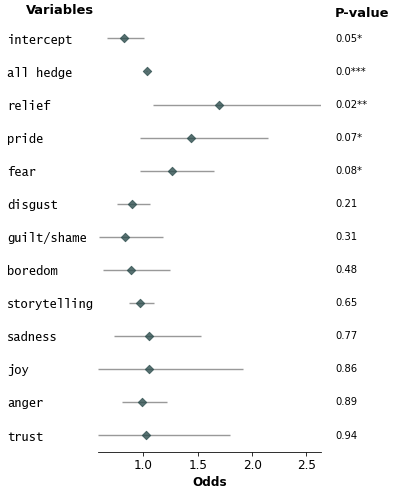

In [16]:
params = full_multi_model.params
conf = full_multi_model.conf_int()
conf['Odds'] = full_multi_model.params
conf.columns = ['5%', '95%', 'Effect']
conf = np.exp(conf)
conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(params.index)[1:]]
conf["P-value"] = full_multi_model.pvalues

fp.forestplot(conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Variables",
              # ylabel="Odds (95% Conf. Int.)",  # y-label title
              xlabel="Odds",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              # xticks=[-1,-.5,0,.5, 1],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                #  'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/cmv_multilinear_forestplot.svg", bbox_inches="tight", format="svg")
print(conf["P-value"])

### Multicolinearity Checks

In [ ]:
# Check for multicolinearity between all independent variables (params[1:]) of the full model
v = cmv[list(params.index)[1:]]
vif_data = pd.DataFrame() 
vif_data["feature"] = list(map(re_feats, v.columns))
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
vif_data.sort_values("VIF",inplace=True)
print("Full variable set:")
vif_latex = vif_data.to_latex(float_format="%.4f",index=False)
vif_data

Full variable set:
\begin{tabular}{lr}
\toprule
feature & VIF \\
\midrule
disgust & 3.6382 \\
surprise & 1.7695 \\
guilt/shame & 2.5316 \\
boredom & 1.3788 \\
storytelling & 1.4541 \\
fear & 1.6016 \\
trust & 1.3421 \\
relief & 1.4560 \\
pride & 2.7428 \\
anger & 4.8713 \\
joy & 2.3998 \\
final hedge & 1.6541 \\
sadness & 2.1536 \\
\bottomrule
\end{tabular}



,feature,VIF
0,disgust,3.638174
1,surprise,1.769549
2,guilt/shame,2.531632
3,boredom,1.378848
4,storytelling,1.454081
5,fear,1.601612
6,trust,1.342082
7,relief,1.456048
8,pride,2.742756
9,anger,4.871331


## Full Model with Interaction

In [17]:
# Using forward selection function to calculate best features
full_result = poly_forward_selection(data, 'persuasiveness')
full_model = full_result["model"]
full_remaining = full_result["remaining"]
full_sign = full_result["significance"]
full_r2 = full_result["r2"]
print(full_model.model.formula)
print(full_model.summary())
print(full_remaining)
list(zip(full_r2, full_sign))

names = map(re_feats,list(full_model.params.index)[1:len(full_r2)+1])
r_list = pd.DataFrame(list(zip(names, full_r2, full_sign)), columns=("Emotion", "\\textbf{pseudo-\\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.4f",index=False))

prob_fear_masked_agg:prob_disgust_masked_agg
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
prob_sadness_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691672
         Iterations 4
prob_joy_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 4
prob_trust_masked_agg:prob_fear_masked_agg
Optimization terminated successfully.
         Current function value: 0.691916
         Iterations 4
prob_relief_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691705
         Iterations 4
prob_relief_masked_agg:prob_guilt_shame_masked_agg
Optimization terminated successfully.
         Current function value: 0.691886
         Iterations 4
prob_storytelling_mixed_domain:prob_disgust_masked_agg
Optimization terminated successfully.
         Current functi

In [56]:
print(full_model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                               &  persuasiveness  & \textbf{  No. Observations:  } &    11567    \\
\textbf{Model:}                                                       &      Logit       & \textbf{  Df Residuals:      } &    11559    \\
\textbf{Method:}                                                      &       MLE        & \textbf{  Df Model:          } &        7    \\
\textbf{Date:}                                                        & Wed, 19 Feb 2025 & \textbf{  Pseudo R-squ.:     } &  0.004219   \\
\textbf{Time:}                                                        &     13:31:48     & \textbf{  Log-Likelihood:    } &   -7970.5   \\
\textbf{converged:}                                                   &       True       & \textbf{  LL-Null:           } &   -8004.2   \\
\textbf{Covariance Type:}                                             &    nonrobust     & \textbf{  LLR p-value:       

\begin{tabular}{rrrlr}
\toprule
5% & 95% & Effect & Variables & P-value \\
\midrule
1.0576 & 1.2322 & 1.1416 & intercept & 0.0007 \\
0.1952 & 0.5677 & 0.3329 & disgust : guilt/shame & 0.0001 \\
9.8180 & 4170.1422 & 202.3421 & fear : pride & 0.0006 \\
0.1228 & 0.5177 & 0.2522 & surprise & 0.0002 \\
1.5943 & 14.3770 & 4.7876 & anger : relief & 0.0052 \\
1.7109 & 5.6284 & 3.1031 & pride : storytelling & 0.0002 \\
0.2380 & 0.7706 & 0.4282 & boredom : storytelling & 0.0047 \\
0.0033 & 0.7454 & 0.0492 & pride : trust & 0.0299 \\
\bottomrule
\end{tabular}



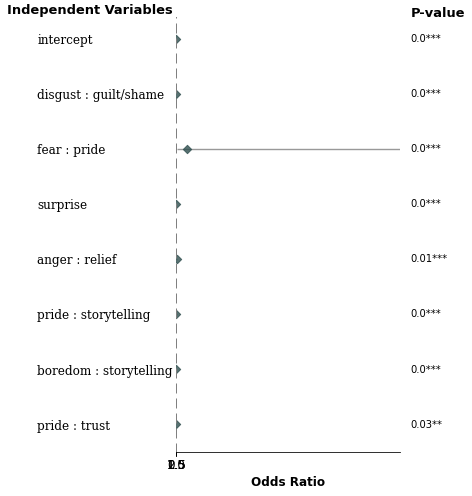

In [ ]:
full_params = full_model.params
full_conf = full_model.conf_int()
full_conf['Odds'] = full_model.params
full_conf.columns = ['5%', '95%', 'Effect']
full_conf = np.exp(full_conf)
full_conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(full_params.index)[1:]]
full_conf["P-value"] = full_model.pvalues

fp.forestplot(full_conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Independent Variables",
              # ylabel="Odds (95% Conf. Int.)",  # y-label title
              xlabel="Odds Ratio",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              xticks=[.5, 1,1.5,2.5],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )
plt.savefig("img/cmv_poly_forestplot.svg", bbox_inches="tight", format="svg")

full_conf.set_index("Variables")
print(full_conf.to_latex(float_format="%.4f",index=False))

# References

- Ron Johnston, Kelvyn Jones, and David Manley. 2018. [Confounding and collinearity in regression analysis: a cautionary tale and an alternative procedure, illustrated by studies of British voting behaviour](https://link.springer.com/article/10.1007/s11135-017-0584-6). _Qual Quant_ 52 (1957-1976).